In [2]:
import math
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from typing import Optional, List
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights
from torch import Tensor
from matplotlib import cm
from torchvision.transforms.functional import to_pil_image
import os  

In [3]:
def process_image_multi_classes(img_path, class_A, class_B, model_weights=ResNet50_Weights.DEFAULT):  
    """  
    处理图片，分别计算样本被分类为子类A和子类B时的通道权重  

    Args:  
        img_path (str): 输入图片的路径  
        class_A (int): 子类A的类别索引  
        class_B (int): 子类B的类别索引  
        model_weights: 模型的预训练权重，默认为ResNet50的默认权重  

    Returns:  
        tuple: (weight_A, weight_B)，分别表示子类A和子类B的梯度加权值  
    """  
    # 定义预处理步骤  
    test_transform = transforms.Compose([  
        transforms.Resize(512),  
        transforms.ToTensor(),  
        transforms.Normalize(  
            mean=[0.485, 0.456, 0.406],  
            std=[0.229, 0.224, 0.225]  
        )  
    ])  

    # 获取设备  
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

    # 初始化模型  
    model = resnet50(weights=model_weights).eval().to(device)  

    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  
        print(f"跳过非图片文件：{img_path}")  
        return None, None  

    # 加载图片  
    img_pil = Image.open(img_path)  

    # 预处理图片  
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device)  

    # 定义前向hook  
    def forward_hook(module, inp, outp):  
        feature_map.append(outp)  

    # 定义反向hook  
    def backward_hook(module, inp, outp):  
        grad.append(outp)  

    # 初始化容器  
    feature_map = []  
    grad = []  

    # 注册hook  
    hook_layer = model.layer4[-1]  
    hook_handle = hook_layer.register_forward_hook(forward_hook)  
    grad_hook_handle = hook_layer.register_full_backward_hook(backward_hook)  

    try:  
        # 前向传播  
        out = model(input_tensor)  
        # 计算权重_A  
        score_A = out[:, class_A].sum()  
        model.zero_grad()  
        score_A.backward(retain_graph=False)  
        weights_A = grad[0][0].squeeze(0).mean(dim=(1, 2)).detach().cpu()  

        # 清理梯度    
        model.zero_grad()  
        if any(p.grad is not None for p in model.parameters()):  
            print("警告：梯度未被正确清除!")  

        # 移除旧的HOOK  
        hook_handle.remove()  
        grad_hook_handle.remove()  

        # 清空grad列表  
        grad.clear()  

        # 重新注册HOOK  
        hook_handle = hook_layer.register_forward_hook(forward_hook)  
        grad_hook_handle = hook_layer.register_full_backward_hook(backward_hook)  

        # 再次前向传播  
        out = model(input_tensor)  

        # 计算权重_B  
        score_B = out[:, class_B].sum()  
        score_B.backward(retain_graph=False)  
        weights_B = grad[0][0].squeeze(0).mean(dim=(1, 2)).detach().cpu()  

        return weights_A, weights_B  

    except Exception as e:  
        print(f"处理过程中出现错误：{e}")  
        return None, None  

    finally:  
        # 删除hook并清理数据  
        hook_handle.remove()  
        grad_hook_handle.remove()  
        feature_map.clear()  
        grad.clear()  

        # 删除GPU上的张量并释放内存  
        if input_tensor.is_cuda:  
            del input_tensor  
            torch.cuda.empty_cache()  

        if 'out' in locals():  
            del out  
        if 'score_A' in locals():  
            del score_A  
        if 'score_B' in locals():  
            del score_B  

In [4]:
def compute_weight_diff_stats(weight_A, weight_B, threshold=1e-8):  
    """  
    计算两个权重之间的绝对差值，并统计非零channel的数量  

    Args:  
        weight_A (Tensor): 第一个权重张量  
        weight_B (Tensor): 第二个权重张量  
        threshold (float, optional): 判断为非零的阈值。默认为1e-8。  

    Returns:  
        tuple: (abs_diff, non_zero_count)  
            - abs_diff (Tensor):绝对差值 tensor，shape为 (num_classes,)  
            - non_zero_count (int): 非零的channel数量  
    """  
    if weight_A is None or weight_B is None:  
        raise ValueError("输入的权重不能为 None")  

    if not isinstance(weight_A, torch.Tensor) or not isinstance(weight_B, torch.Tensor):  
        raise TypeError("输入必须是 torch.Tensor 类型")  

    if weight_A.shape != weight_B.shape:  
        raise ValueError("两个权重的 shape 必须相同")  

    # 计算绝对差值  
    abs_diff = torch.abs(weight_A - weight_B)  

    # 统计非零channel的数量（绝对值大于阈值的为非零）  
    non_zero_count = (abs_diff > threshold).sum().item()  

    return abs_diff, non_zero_count  

In [5]:
img_path="dataset/波斯猫/1.jpg"
weight_A, weight_B = process_image_multi_classes(img_path, class_A=283, class_B=285) 
# 计算差值和统计非零channel数量  
abs_diff, non_zero_count = compute_weight_diff_stats(weight_A, weight_B)  

# 输出结果  
print(f"绝对差值：{abs_diff}")  
print(f"非零channel数量：{non_zero_count}") 

绝对差值：tensor([3.1520e-05, 2.3000e-05, 1.0630e-04,  ..., 1.1230e-05, 1.2130e-04,
        3.3094e-05])
非零channel数量：2048


In [6]:
img_path="dataset/波斯猫/1.jpg"
weight_A, weight_B = process_image_multi_classes(img_path, class_A=283, class_B=283) 
# 计算差值和统计非零channel数量  
abs_diff, non_zero_count = compute_weight_diff_stats(weight_A, weight_B)  

# 输出结果  
print(f"绝对差值：{abs_diff}")  
print(f"非零channel数量：{non_zero_count}") 

绝对差值：tensor([0., 0., 0.,  ..., 0., 0., 0.])
非零channel数量：0


In [7]:
def batch_process_images(directory, class_A, class_B, model_weights=ResNet50_Weights.DEFAULT):  
    """  
    批量处理目录中的图片文件，计算每个图片的weight_A和weight_B的绝对差值  

    Args:  
        directory (str): 包含图片文件的目录路径  
        class_A (int): 子类A的类别索引  
        class_B (int): 子类B的类别索引  
        model_weights: 模型的预训练权重，默认为ResNet50的默认权重  

    Returns:  
        list: 包含每张图片计算得到的weight_A和weight_B的绝对差值 tensor 的列表  
    """  
    # 初始化结果列表  
    abs_diff_list = []  

    # 遍历目录中的文件  
    for filename in os.listdir(directory):  
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  
            img_path = os.path.join(directory, filename)  
            try:  
                # 调用process_image_multi_classes获取权重  
                weight_A, weight_B = process_image_multi_classes(img_path, class_A, class_B, model_weights)  
                if weight_A is not None and weight_B is not None: 
                    
                    # # 计算绝对差值  
                    # abs_diff = torch.abs(weight_A - weight_B)  
                    
                    # 计算差值  
                    difference = weight_A - weight_B  
                    
                    # 计算绝对值  
                    abs_diff = torch.abs(difference)  
                    
                    # 检查abs_diff中是否有负数  
                    if torch.any(abs_diff < 0):  
                        raise ValueError("Unexpected negative values found in absolute difference.")
                    abs_diff_list.append(abs_diff)  
                else:  
                    print(f"跳过无法处理的文件：{filename}")  
            except Exception as e:  
                print(f"处理文件 {filename} 时出现错误：{e}")  
                continue  

    return abs_diff_list

In [8]:
#类别n2101006 戈登雪达犬   对应class_index=214
#类别n2105505 匈牙利牧羊犬 对应class_index=228
directory = "dataset/n02101006"  
class_A = 214  
class_B = 228  

abs_diff_list1 = batch_process_images(directory, class_A, class_B)

In [9]:
#类别n2101006 戈登雪达犬   对应class_index=214
#类别n2105505 匈牙利牧羊犬 对应class_index=228
directory = "dataset/n02105505"  
class_A = 214  
class_B = 228  

abs_diff_list2 = batch_process_images(directory, class_A, class_B)

In [10]:
import matplotlib.pyplot as plt  
import random  
import torch  
import numpy as np  

def visualize_random_tensors(tensor_list, num_samples=10, seed=None):  
    """  
    随机选择指定数量的张量进行可视化，展示每个张量各维度的值  
    
    Args:  
        tensor_list (list): 包含torch.Tensor的列表，每个Tensor形状为(2048,)  
        num_samples (int): 要可视化的样本数量，默认为10  
        seed (int): 随机种子，用于可重复性，默认为None  
    
    Returns:  
        matplotlib.figure.Figure: 生成的图表对象  
    """  
    # 参数校验  
    if not isinstance(tensor_list, list) or len(tensor_list) == 0:  
        raise ValueError("输入必须是非空列表")  
    
    if not all(isinstance(t, torch.Tensor) and t.shape == (2048,) for t in tensor_list):  
        raise ValueError("列表中所有元素必须是形状为(2048,)的torch.Tensor")  
    
    num_samples = min(num_samples, len(tensor_list))  
    
    # 设置随机种子  
    if seed is not None:  
        random.seed(seed)  
    
    # 随机选择样本  
    selected_indices = random.sample(range(len(tensor_list)), num_samples)  
    selected_tensors = [tensor_list[i] for i in selected_indices]  
    
    # 创建图表  
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 2*num_samples))  
    if num_samples == 1:  
        axes = [axes]  # 确保axes始终是列表  
    
    # 绘制每个张量  
    for idx, (tensor, ax) in enumerate(zip(selected_tensors, axes)):  
        # 转换为numpy数组  
        values = tensor.numpy()  
        dims = np.arange(len(values))  # 0-2047的维度索引  
        
        # 绘制线图  
        ax.plot(dims, values, linewidth=1, alpha=0.7)  
        
        # 设置图表元素  
        ax.set_title(f"Sample {idx+1} ")  
        ax.set_xlabel("Dimension Index ")  
        ax.set_ylabel("Value")  
        ax.grid(True, alpha=0.3)  
        
        # 设置x轴范围  
        ax.set_xlim(0, 2047)  
    
    # 调整布局  
    plt.tight_layout()  
    fig.suptitle(f"Visualization of {num_samples} Random 2048-D Tensors", y=1.02)  
    
    return fig  



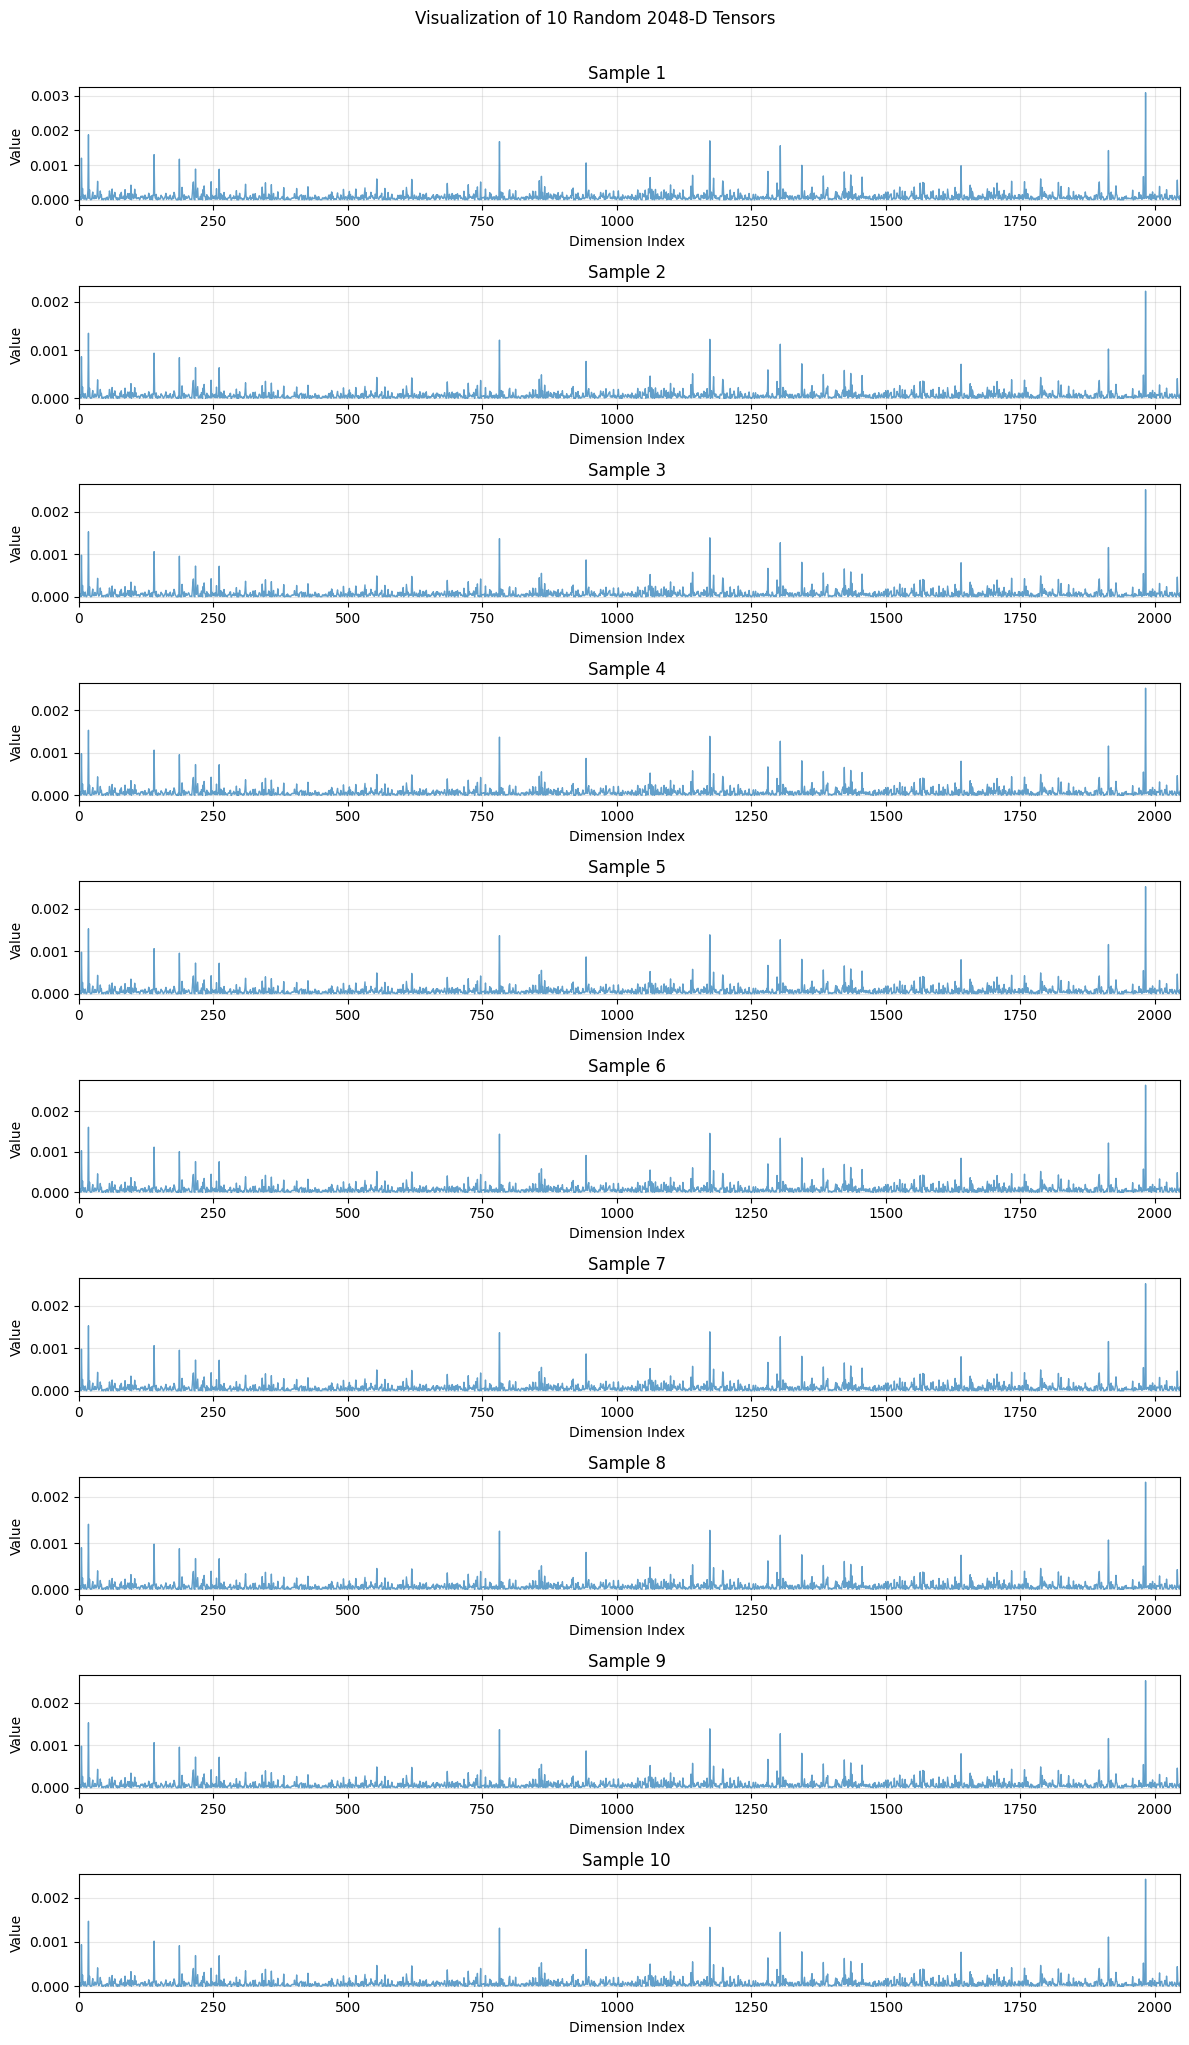

In [11]:
 # 调用函数  
fig = visualize_random_tensors(abs_diff_list1, num_samples=10, seed=42)  
# 显示图表  
plt.show()  

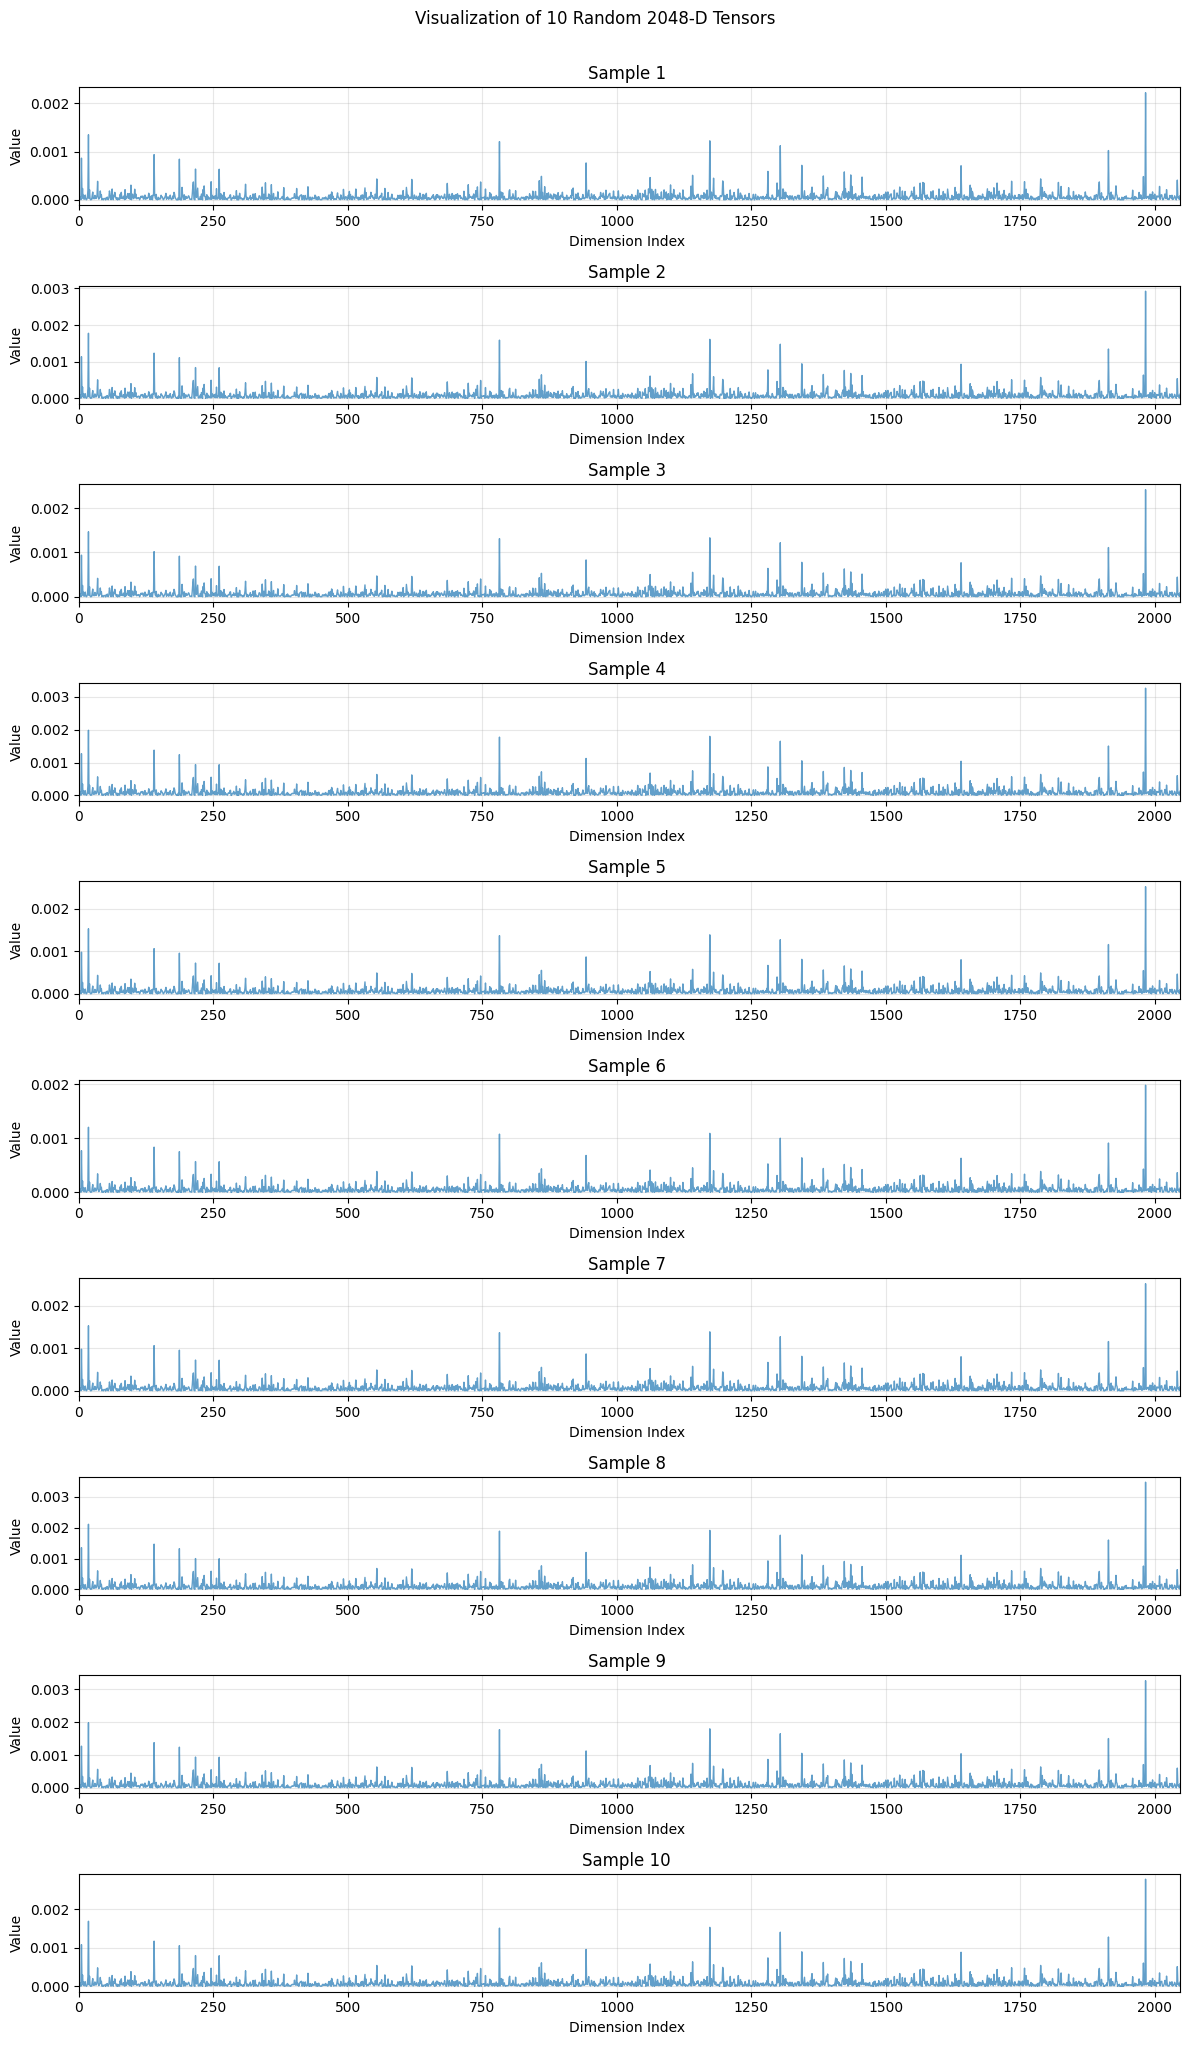

In [11]:
 # 调用函数  
fig = visualize_random_tensors(abs_diff_list2, num_samples=10, seed=42)  
# 显示图表  
plt.show() 